In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

import process_data
import network
import config

In [2]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

normalized_scan_val_set_full = np.load('normalized_scan_100610_full.npy')

In [3]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3
bvals_all_val_set = np.loadtxt(config.data_folder2 + '/100610/bvals') * 1e-3

In [4]:
big_b_indices_100206 = np.where(bvals_all_100206 != 0.005)[0]
big_b_indices_val_set = np.where(bvals_all_val_set != 0.005)[0]

In [5]:
bvals_100206 = bvals_all_100206[big_b_indices_100206]
bvals_val_set = bvals_all_100206[big_b_indices_val_set]

In [6]:
normalized_scan_100206_no_b5 = normalized_scan_100206_full[:, big_b_indices_100206]
normalized_scan_val_set_no_b5 = normalized_scan_val_set_full[:, big_b_indices_val_set]

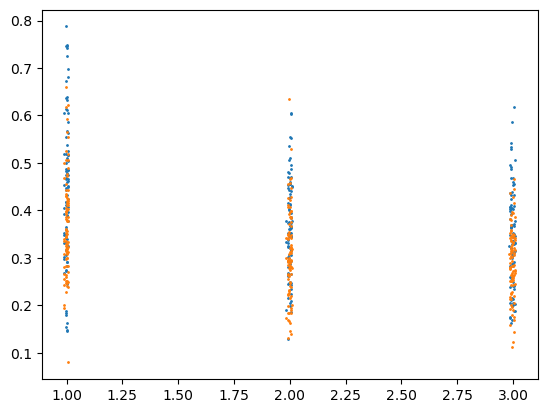

In [7]:
plt.plot(bvals_100206, normalized_scan_100206_no_b5[42,:], "o", markersize = 1)
plt.plot(bvals_val_set, normalized_scan_val_set_no_b5[42,:], "o", markersize = 1)

In [8]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

n_val_set_all = np.loadtxt(config.data_folder2 + '/100610/bvecs')

In [9]:
n_100206 = n_100206_all[:,big_b_indices_100206].T
print(n_100206.shape)

b_values_100206 = torch.FloatTensor(bvals_100206)
gradient_directions_100206 = torch.FloatTensor(n_100206)

n_val_set = n_val_set_all[:,big_b_indices_val_set].T
print(n_val_set.shape)

b_values_val_set = torch.FloatTensor(bvals_val_set)
gradient_directions_val_set = torch.FloatTensor(n_val_set)

(270, 3)
(270, 3)


In [10]:
batch_size = 128
num_batches = len(normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [11]:
val_set = torch.from_numpy(normalized_scan_val_set_no_b5.astype(np.float32))
print(val_set.shape)
print(type(val_set))

torch.Size([880154, 270])
<class 'torch.Tensor'>


In [38]:
# net_golden_std = network.BallStickNet(gradient_directions_100206, b_values_100206)
# net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
# criterion = nn.MSELoss()
# optimizer = optim.Adam(net_golden_std.parameters(), lr = 0.00001)

net = network.BallStickNet(gradient_directions_100206, b_values_100206)

# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [39]:
train_loss_list=[]
avg_train_loss_list=[]

val_loss_list = []
avg_val_loss_list=[]


# Best loss
best_train_loss = 1e16
best_val_loss = 1e16
num_bad_epochs_train = 0
num_bad_epochs_val = 0
patience = 20

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad training epochs: {}; Bad validation epochs: {}".format(epoch, num_bad_epochs_train, num_bad_epochs_val))
    current_learning_rate = optimizer.param_groups[0]['lr']
    if current_learning_rate != 0.00001:
        print("Current learning rate: {}".format(current_learning_rate))
    
    net.train()
    running_train_loss = 0.
    
#     Training
    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        # if i == 1:
        #     print("Prediction:")
        #     print(X_pred)
        #     print("Real:")
        #     print(X_batch)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    train_loss_list.append(running_train_loss)
    avg_train_loss_list.append(running_train_loss/num_batches)
    print("Loss: {}; Average Loss: {}".format(running_train_loss, running_train_loss/num_batches))
    
#     Validation
    temp_model = net.state_dict()
    val_net = network.BallStickNet(gradient_directions_val_set, b_values_val_set)
    val_net.load_state_dict(temp_model)
    val_net.eval()
    with torch.no_grad():
        val_pred, _, _, _, _, _, _, _ = val_net(val_set)
        # print("Val Prediction:")
        # print(val_pred)
        # print("Val Real:")
        # print(val_set)
        val_loss = criterion(val_pred.type(torch.FloatTensor), val_set.type(torch.FloatTensor))
        running_val_loss = val_loss.item()
        val_loss_list.append(running_val_loss)
        print("Validation Loss: {}".format(running_val_loss))
        
    scheduler.step(running_val_loss)
    
    if running_train_loss < best_train_loss:
        best_train_loss = running_train_loss
        num_bad_epochs_train = 0
        
    elif running_train_loss >= best_train_loss:
        num_bad_epochs_train = num_bad_epochs_train + 1

    if running_val_loss < best_val_loss:
        print("############### Saving good model for validation set ###############################")
        final_model_valset = net.state_dict()
        best_val_loss = running_val_loss
        num_bad_epochs_val = 0
    elif running_val_loss >= best_val_loss:
        num_bad_epochs_val += 1
        if num_bad_epochs_val == patience:
            print("Done, best training loss per epoch: {}; best validation loss: {}".format(best_train_loss, best_val_loss))
            break

print("Done") 
net.load_state_dict(final_model_valset)

-----------------------------------------------------------------
Epoch: 0; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.15it/s]


Loss: 459.5175788924098; Average Loss: 0.06287870537662969
Validation Loss: 0.05589739605784416
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 1; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.88it/s]


Loss: 381.8490004166961; Average Loss: 0.05225082107508156
Validation Loss: 0.05292742699384689
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 2; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.83it/s]


Loss: 365.73529513552785; Average Loss: 0.050045880560417054
Validation Loss: 0.05179036036133766
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 3; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.80it/s]


Loss: 358.15413596481085; Average Loss: 0.04900850245823903
Validation Loss: 0.05130650848150253
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 4; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.64it/s]


Loss: 354.42271752282977; Average Loss: 0.048497908801700844
Validation Loss: 0.05077904090285301
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 5; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.51it/s]


Loss: 352.38260060176253; Average Loss: 0.04821874666143439
Validation Loss: 0.05076049640774727
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 6; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.54it/s]


Loss: 350.9449496604502; Average Loss: 0.048022023763061056
Validation Loss: 0.050590090453624725
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 7; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.16it/s]


Loss: 349.87425984069705; Average Loss: 0.047875514482854
Validation Loss: 0.05045368894934654
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 8; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.88it/s]


Loss: 349.06132684648037; Average Loss: 0.047764275704225555
Validation Loss: 0.050399359315633774
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 9; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.06it/s]


Loss: 348.33138247951865; Average Loss: 0.04766439278592209
Validation Loss: 0.05024944618344307
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 10; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:20<00:00, 90.39it/s]


Loss: 347.7621428593993; Average Loss: 0.04758650011759706
Validation Loss: 0.05026322230696678
-----------------------------------------------------------------
Epoch: 11; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.48it/s]


Loss: 347.23733603581786; Average Loss: 0.047514687470692096
Validation Loss: 0.05018148198723793
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 12; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 117.88it/s]


Loss: 346.7708919234574; Average Loss: 0.04745086096380095
Validation Loss: 0.050178613513708115
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 13; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:13<00:00, 99.62it/s]


Loss: 346.3799128718674; Average Loss: 0.04739736081990523
Validation Loss: 0.050102055072784424
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 14; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.49it/s]


Loss: 346.00984048098326; Average Loss: 0.04734672146702015
Validation Loss: 0.050050489604473114
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 15; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.71it/s]


Loss: 345.7242737002671; Average Loss: 0.047307645552855375
Validation Loss: 0.0499994158744812
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 16; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.81it/s]


Loss: 345.40479078143835; Average Loss: 0.047263928678357735
Validation Loss: 0.050084128975868225
-----------------------------------------------------------------
Epoch: 17; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.75it/s]


Loss: 345.15335100516677; Average Loss: 0.04722952257870372
Validation Loss: 0.0499936118721962
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 18; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.99it/s]


Loss: 344.86159379407763; Average Loss: 0.047189599588680575
Validation Loss: 0.0499645471572876
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 19; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.91it/s]


Loss: 344.62309239432216; Average Loss: 0.047156963929162854
Validation Loss: 0.05006551370024681
-----------------------------------------------------------------
Epoch: 20; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.22it/s]


Loss: 344.4673150703311; Average Loss: 0.04713564792971143
Validation Loss: 0.049860935658216476
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 21; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.65it/s]


Loss: 344.2594205774367; Average Loss: 0.04710720040742155
Validation Loss: 0.04987237975001335
-----------------------------------------------------------------
Epoch: 22; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.38it/s]


Loss: 344.1110824495554; Average Loss: 0.04708690236036609
Validation Loss: 0.049852315336465836
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 23; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.76it/s]


Loss: 343.9279908388853; Average Loss: 0.04706184877379383
Validation Loss: 0.049833033233881
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 24; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.60it/s]


Loss: 343.7993241623044; Average Loss: 0.04704424249621023
Validation Loss: 0.04981611296534538
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 25; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.86it/s]


Loss: 343.64898520335555; Average Loss: 0.04702367066274706
Validation Loss: 0.04980248212814331
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 26; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.21it/s]


Loss: 343.50241389498115; Average Loss: 0.047003614380812964
Validation Loss: 0.049843866378068924
-----------------------------------------------------------------
Epoch: 27; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.10it/s]


Loss: 343.45559637248516; Average Loss: 0.04699720804221198
Validation Loss: 0.04980049282312393
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 28; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.09it/s]


Loss: 343.2464275807142; Average Loss: 0.04696858614952302
Validation Loss: 0.04977986961603165
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 29; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.01it/s]


Loss: 343.17758755758405; Average Loss: 0.0469591663324554
Validation Loss: 0.04973600432276726
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 30; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.49it/s]


Loss: 343.07021824270487; Average Loss: 0.046944474307978226
Validation Loss: 0.04977845028042793
-----------------------------------------------------------------
Epoch: 31; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.40it/s]


Loss: 343.0132538676262; Average Loss: 0.04693667951116943
Validation Loss: 0.04970235750079155
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 32; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.19it/s]


Loss: 342.9280779771507; Average Loss: 0.046925024353742566
Validation Loss: 0.04979933053255081
-----------------------------------------------------------------
Epoch: 33; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.37it/s]


Loss: 342.81306979060173; Average Loss: 0.04690928705399586
Validation Loss: 0.04965704306960106
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 34; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.48it/s]


Loss: 342.7343452088535; Average Loss: 0.046898514670067525
Validation Loss: 0.04978584870696068
-----------------------------------------------------------------
Epoch: 35; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.09it/s]


Loss: 342.6682858876884; Average Loss: 0.04688947535408982
Validation Loss: 0.04974042624235153
-----------------------------------------------------------------
Epoch: 36; Bad training epochs: 0; Bad validation epochs: 2
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.52it/s]


Loss: 342.60261084139347; Average Loss: 0.04688048862088033
Validation Loss: 0.04964664950966835
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 37; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.55it/s]


Loss: 342.4921160414815; Average Loss: 0.04686536891645888
Validation Loss: 0.04974767938256264
-----------------------------------------------------------------
Epoch: 38; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.10it/s]


Loss: 342.4014416076243; Average Loss: 0.04685296135845981
Validation Loss: 0.04960193857550621
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 39; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.10it/s]


Loss: 342.4073158055544; Average Loss: 0.046853765162226925
Validation Loss: 0.049636323004961014
-----------------------------------------------------------------
Epoch: 40; Bad training epochs: 1; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.57it/s]


Loss: 342.2887692190707; Average Loss: 0.046837543680770484
Validation Loss: 0.049734875559806824
-----------------------------------------------------------------
Epoch: 41; Bad training epochs: 0; Bad validation epochs: 2
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.59it/s]


Loss: 342.2242531441152; Average Loss: 0.04682871553696158
Validation Loss: 0.04962117597460747
-----------------------------------------------------------------
Epoch: 42; Bad training epochs: 0; Bad validation epochs: 3
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.80it/s]


Loss: 342.13417292013764; Average Loss: 0.046816389288469845
Validation Loss: 0.04964883252978325
-----------------------------------------------------------------
Epoch: 43; Bad training epochs: 0; Bad validation epochs: 4
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.05it/s]


Loss: 342.11006055399776; Average Loss: 0.04681308984044852
Validation Loss: 0.04964987188577652
-----------------------------------------------------------------
Epoch: 44; Bad training epochs: 0; Bad validation epochs: 5
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.19it/s]


Loss: 342.0247275047004; Average Loss: 0.04680141317798309
Validation Loss: 0.04965180531144142
-----------------------------------------------------------------
Epoch: 45; Bad training epochs: 0; Bad validation epochs: 6
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.17it/s]


Loss: 342.0371034294367; Average Loss: 0.04680310665427431
Validation Loss: 0.04963891580700874
-----------------------------------------------------------------
Epoch: 46; Bad training epochs: 1; Bad validation epochs: 7
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.67it/s]


Loss: 341.9340106062591; Average Loss: 0.046788999809285595
Validation Loss: 0.049577564001083374
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 47; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.12it/s]


Loss: 341.883172031492; Average Loss: 0.04678204324459387
Validation Loss: 0.04966243356466293
-----------------------------------------------------------------
Epoch: 48; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.51it/s]


Loss: 341.82121009007096; Average Loss: 0.04677356459907922
Validation Loss: 0.04967978969216347
-----------------------------------------------------------------
Epoch: 49; Bad training epochs: 0; Bad validation epochs: 2
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.75it/s]


Loss: 341.7716924250126; Average Loss: 0.04676678878284245
Validation Loss: 0.04958190396428108
-----------------------------------------------------------------
Epoch: 50; Bad training epochs: 0; Bad validation epochs: 3
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.36it/s]


Loss: 341.7653839215636; Average Loss: 0.046765925550296066
Validation Loss: 0.0495777353644371
-----------------------------------------------------------------
Epoch: 51; Bad training epochs: 0; Bad validation epochs: 4
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.14it/s]


Loss: 341.6469468548894; Average Loss: 0.04674971905512991
Validation Loss: 0.04954509809613228
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 52; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.45it/s]


Loss: 341.66524017974734; Average Loss: 0.046752222246818194
Validation Loss: 0.049588918685913086
-----------------------------------------------------------------
Epoch: 53; Bad training epochs: 1; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 146.01it/s]


Loss: 341.6108520999551; Average Loss: 0.046744779980836766
Validation Loss: 0.04967930167913437
-----------------------------------------------------------------
Epoch: 54; Bad training epochs: 0; Bad validation epochs: 2
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.24it/s]


Loss: 341.56268559768796; Average Loss: 0.04673818905277613
Validation Loss: 0.049595195800065994
-----------------------------------------------------------------
Epoch: 55; Bad training epochs: 0; Bad validation epochs: 3
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.86it/s]


Loss: 341.4915307164192; Average Loss: 0.04672845247898457
Validation Loss: 0.04953166842460632
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 56; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 102.44it/s]


Loss: 341.46796606481075; Average Loss: 0.046725227978217126
Validation Loss: 0.04959625378251076
-----------------------------------------------------------------
Epoch: 57; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.39it/s]


Loss: 341.43885431066155; Average Loss: 0.0467212444322197
Validation Loss: 0.049713850021362305
-----------------------------------------------------------------
Epoch: 58; Bad training epochs: 0; Bad validation epochs: 2
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.54it/s]


Loss: 341.40714398398995; Average Loss: 0.04671690530705938
Validation Loss: 0.04950878769159317
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 59; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.85it/s]


Loss: 341.3856961019337; Average Loss: 0.04671397045729799
Validation Loss: 0.04953325167298317
-----------------------------------------------------------------
Epoch: 60; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.89it/s]


Loss: 341.3454353399575; Average Loss: 0.04670846132183326
Validation Loss: 0.04956376180052757
-----------------------------------------------------------------
Epoch: 61; Bad training epochs: 0; Bad validation epochs: 2
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.36it/s]


Loss: 341.2968297712505; Average Loss: 0.04670181031352634
Validation Loss: 0.04947604611515999
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 62; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.26it/s]


Loss: 341.2588001228869; Average Loss: 0.046696606475490815
Validation Loss: 0.049512170255184174
-----------------------------------------------------------------
Epoch: 63; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.96it/s]


Loss: 341.25297855585814; Average Loss: 0.046695809873543805
Validation Loss: 0.049542587250471115
-----------------------------------------------------------------
Epoch: 64; Bad training epochs: 0; Bad validation epochs: 2
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.58it/s]


Loss: 341.20611054077744; Average Loss: 0.04668939662572215
Validation Loss: 0.04954952001571655
-----------------------------------------------------------------
Epoch: 65; Bad training epochs: 0; Bad validation epochs: 3
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.85it/s]


Loss: 341.2396847233176; Average Loss: 0.046693990794104766
Validation Loss: 0.04954836517572403
-----------------------------------------------------------------
Epoch: 66; Bad training epochs: 1; Bad validation epochs: 4
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.79it/s]


Loss: 341.1094484962523; Average Loss: 0.04667616974497158
Validation Loss: 0.04967627301812172
-----------------------------------------------------------------
Epoch: 67; Bad training epochs: 0; Bad validation epochs: 5
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.11it/s]


Loss: 341.0848518125713; Average Loss: 0.04667280402470871
Validation Loss: 0.04949256032705307
-----------------------------------------------------------------
Epoch: 68; Bad training epochs: 0; Bad validation epochs: 6
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.19it/s]


Loss: 341.04198978096247; Average Loss: 0.0466669389410184
Validation Loss: 0.04950718581676483
-----------------------------------------------------------------
Epoch: 69; Bad training epochs: 0; Bad validation epochs: 7
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.53it/s]


Loss: 341.03243470191956; Average Loss: 0.04666563145893809
Validation Loss: 0.04950568825006485
-----------------------------------------------------------------
Epoch: 70; Bad training epochs: 0; Bad validation epochs: 8
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.79it/s]


Loss: 340.9755734242499; Average Loss: 0.04665785076960179
Validation Loss: 0.04955098778009415
-----------------------------------------------------------------
Epoch: 71; Bad training epochs: 0; Bad validation epochs: 9
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.76it/s]


Loss: 341.0096198655665; Average Loss: 0.04666250956014867
Validation Loss: 0.04951271414756775
-----------------------------------------------------------------
Epoch: 72; Bad training epochs: 1; Bad validation epochs: 10
Current learning rate: 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.20it/s]


Loss: 340.9628581441939; Average Loss: 0.046656110857169385
Validation Loss: 0.049549564719200134
Epoch 00073: reducing learning rate of group 0 to 1.0000e-05.
-----------------------------------------------------------------
Epoch: 73; Bad training epochs: 0; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.85it/s]


Loss: 340.52454132959247; Average Loss: 0.04659613318686268
Validation Loss: 0.049468718469142914
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 74; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.38it/s]


Loss: 340.40710889548063; Average Loss: 0.046580064161943165
Validation Loss: 0.049453966319561005
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 75; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.53it/s]


Loss: 340.34415056183934; Average Loss: 0.046571449173760174
Validation Loss: 0.04945642128586769
-----------------------------------------------------------------
Epoch: 76; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.84it/s]


Loss: 340.31070844084024; Average Loss: 0.04656687307619598
Validation Loss: 0.04945703595876694
-----------------------------------------------------------------
Epoch: 77; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.52it/s]


Loss: 340.2916457504034; Average Loss: 0.04656426460733489
Validation Loss: 0.049446526914834976
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 78; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.25it/s]


Loss: 340.2884082496166; Average Loss: 0.046563821599564396
Validation Loss: 0.04944753274321556
-----------------------------------------------------------------
Epoch: 79; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.54it/s]


Loss: 340.27497670426965; Average Loss: 0.04656198367600844
Validation Loss: 0.0494549386203289
-----------------------------------------------------------------
Epoch: 80; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.39it/s]


Loss: 340.25260469689965; Average Loss: 0.04655892237231796
Validation Loss: 0.049446143209934235
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 81; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.35it/s]


Loss: 340.24617018178105; Average Loss: 0.04655804189679544
Validation Loss: 0.04946400225162506
-----------------------------------------------------------------
Epoch: 82; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.62it/s]


Loss: 340.2488542534411; Average Loss: 0.04655840917534772
Validation Loss: 0.04944349825382233
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 83; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.80it/s]


Loss: 340.25541069731116; Average Loss: 0.04655930633515479
Validation Loss: 0.049442462623119354
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 84; Bad training epochs: 2; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.88it/s]


Loss: 340.23270592838526; Average Loss: 0.04655619949758966
Validation Loss: 0.04944518208503723
-----------------------------------------------------------------
Epoch: 85; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.50it/s]


Loss: 340.22440300509334; Average Loss: 0.0465550633559241
Validation Loss: 0.04944978654384613
-----------------------------------------------------------------
Epoch: 86; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.58it/s]


Loss: 340.19975874200463; Average Loss: 0.04655169112506905
Validation Loss: 0.04942674934864044
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 87; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.40it/s]


Loss: 340.20223565772176; Average Loss: 0.04655203005715952
Validation Loss: 0.04943646863102913
-----------------------------------------------------------------
Epoch: 88; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.64it/s]


Loss: 340.2005106136203; Average Loss: 0.046551794008431895
Validation Loss: 0.04945124313235283
-----------------------------------------------------------------
Epoch: 89; Bad training epochs: 2; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.36it/s]


Loss: 340.19000685587525; Average Loss: 0.04655035671262661
Validation Loss: 0.04943712800741196
-----------------------------------------------------------------
Epoch: 90; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.13it/s]


Loss: 340.1743106804788; Average Loss: 0.04654820890537477
Validation Loss: 0.049451794475317
-----------------------------------------------------------------
Epoch: 91; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.37it/s]


Loss: 340.17886724695563; Average Loss: 0.046548832409271435
Validation Loss: 0.04943973943591118
-----------------------------------------------------------------
Epoch: 92; Bad training epochs: 1; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.12it/s]


Loss: 340.1624762304127; Average Loss: 0.046546589522497635
Validation Loss: 0.04943707212805748
-----------------------------------------------------------------
Epoch: 93; Bad training epochs: 0; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.91it/s]


Loss: 340.161458786577; Average Loss: 0.0465464502992032
Validation Loss: 0.049429453909397125
-----------------------------------------------------------------
Epoch: 94; Bad training epochs: 0; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.27it/s]


Loss: 340.1567638106644; Average Loss: 0.04654580785586541
Validation Loss: 0.04945876821875572
-----------------------------------------------------------------
Epoch: 95; Bad training epochs: 0; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.21it/s]


Loss: 340.14989203959703; Average Loss: 0.04654486754783758
Validation Loss: 0.04943900555372238
-----------------------------------------------------------------
Epoch: 96; Bad training epochs: 0; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.10it/s]


Loss: 340.1413534283638; Average Loss: 0.04654369915549587
Validation Loss: 0.049434758722782135
-----------------------------------------------------------------
Epoch: 97; Bad training epochs: 0; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.07it/s]


Loss: 340.1447393745184; Average Loss: 0.046544162475987735
Validation Loss: 0.04945187270641327
Epoch 00098: reducing learning rate of group 0 to 1.0000e-06.
-----------------------------------------------------------------
Epoch: 98; Bad training epochs: 1; Bad validation epochs: 11
Current learning rate: 1.0000000000000002e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.05it/s]


Loss: 340.0748958028853; Average Loss: 0.046534605337012216
Validation Loss: 0.0494341216981411
-----------------------------------------------------------------
Epoch: 99; Bad training epochs: 0; Bad validation epochs: 12
Current learning rate: 1.0000000000000002e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.71it/s]


Loss: 340.06599889695644; Average Loss: 0.04653338791693438
Validation Loss: 0.04943476617336273
-----------------------------------------------------------------
Epoch: 100; Bad training epochs: 0; Bad validation epochs: 13
Current learning rate: 1.0000000000000002e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.47it/s]


Loss: 340.0675253458321; Average Loss: 0.04653359679061742
Validation Loss: 0.049440234899520874
-----------------------------------------------------------------
Epoch: 101; Bad training epochs: 1; Bad validation epochs: 14
Current learning rate: 1.0000000000000002e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.47it/s]


Loss: 340.0646852143109; Average Loss: 0.04653320815740433
Validation Loss: 0.04943707585334778
-----------------------------------------------------------------
Epoch: 102; Bad training epochs: 0; Bad validation epochs: 15
Current learning rate: 1.0000000000000002e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.90it/s]


Loss: 340.0646643526852; Average Loss: 0.04653320530277576
Validation Loss: 0.049433641135692596
-----------------------------------------------------------------
Epoch: 103; Bad training epochs: 0; Bad validation epochs: 16
Current learning rate: 1.0000000000000002e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.59it/s]


Loss: 340.0553121827543; Average Loss: 0.046531925586036436
Validation Loss: 0.04943591728806496
-----------------------------------------------------------------
Epoch: 104; Bad training epochs: 0; Bad validation epochs: 17
Current learning rate: 1.0000000000000002e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.75it/s]


Loss: 340.0629395246506; Average Loss: 0.046532969283613924
Validation Loss: 0.049437928944826126
-----------------------------------------------------------------
Epoch: 105; Bad training epochs: 1; Bad validation epochs: 18
Current learning rate: 1.0000000000000002e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.01it/s]


Loss: 340.06182749941945; Average Loss: 0.04653281711814716
Validation Loss: 0.04943890497088432
-----------------------------------------------------------------
Epoch: 106; Bad training epochs: 2; Bad validation epochs: 19
Current learning rate: 1.0000000000000002e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.77it/s]


Loss: 340.06114706769586; Average Loss: 0.04653272401035794
Validation Loss: 0.04943068325519562
Done, best training loss per epoch: 340.0553121827543; best validation loss: 0.04942674934864044
Done


<All keys matched successfully>

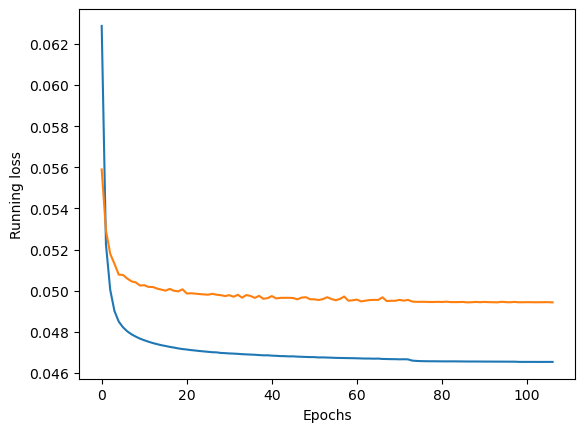

In [40]:
plt.plot(avg_train_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Running loss")
plt.show()

In [41]:
with open('loss_golden_std_retrain04.txt', 'w') as f:
    f.write('train_loss_per_epoch_list: ' + str(train_loss_list) + '\n')
    f.write('\n')
    f.write('avg_train_loss_list: ' + str(avg_train_loss_list) + '\n')
    f.write('\n')
    f.write('val_loss_list: ' + str(val_loss_list) + '\n')

In [42]:
# torch.save(final_model_trainset, 'model_100206_golden_std_retrain_trainset.pt')
torch.save(final_model_valset, 'model_100206_golden_std_retrain04.pt')